In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
import torch
import torchvision
import pytorch_lightning as pl  #for efficient and easy training implementation
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
from dataset import CardiacDataset

In [3]:
class CardiacDetectionModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(weights='DEFAULT')
        # change the number of input channels in the first convolution from 3 to 1 (grayscale)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3),  bias=False)
        # fully connected layer with 4 outputs (2 x,y coordinates of 2 diagonal nodes of BB) 
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4) # it loses the pretrained weights
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        # L2 loss (Mean Squared Error), as we are dealing with continuous values.
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)

        self.log("Train Loss", loss)

        if batch_idx % 100 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss

    # validateino
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        if batch_idx % 100 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss

    def log_images(self, x_ray, pred, label, name):
        try:
            results = []
            
            num_images = min(2, x_ray.shape[0])
            
            for i in range(num_images):
                coords_labels = label[i]
                coords_pred = pred[i]
                
                # Fixed: Handle tensor conversion properly for CPU
                x_ray_item = x_ray[i]
                if x_ray_item.requires_grad:
                    x_ray_item = x_ray_item.detach()
                
                img = ((x_ray_item * 0.252) + 0.494).numpy()[0]
                
                # Ensure image is in correct format for cv2
                img = np.clip(img, 0, 1)  # Ensure values are in [0,1]
                img_vis = (img * 255).astype(np.uint8)  # Convert to 8-bit for cv2
                
                # Convert to 3-channel for colored rectangles
                img_vis = cv2.cvtColor(img_vis, cv2.COLOR_GRAY2RGB)
                
                # Extract label coordinates
                x0_label = max(0, coords_labels[0].int().item())
                y0_label = max(0, coords_labels[1].int().item())
                x1_label = coords_labels[2].int().item()
                y1_label = coords_labels[3].int().item()
                
                # Draw ground truth bounding box (green)
                img_vis = cv2.rectangle(img_vis, (x0_label, y0_label), (x1_label, y1_label), (0, 255, 0), 2)
                
                # Extract prediction coordinates
                x0_pred = max(0, coords_pred[0].int().item())
                y0_pred = max(0, coords_pred[1].int().item())
                x1_pred = coords_pred[2].int().item()
                y1_pred = coords_pred[3].int().item()
                
                # Draw predicted bounding box (red)
                img_vis = cv2.rectangle(img_vis, (x0_pred, y0_pred), (x1_pred, y1_pred), (255, 0, 0), 2)
                
                # Convert back to tensor format
                img_tensor = torch.tensor(img_vis).permute(2, 0, 1).float() / 255.0
                results.append(img_tensor)
            
            if results:
                grid = torchvision.utils.make_grid(results, nrow=2)
                if hasattr(self.logger, 'experiment'):
                    self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)
        
        except Exception as e:
            print(f"Error in log_images: {e}")
            # Continue training even if logging fails
            pass

    def configure_optimizers(self):
        return [self.optimizer]
            

In [6]:
train_root_path = "Processed-Heart-Detection/train/"
train_subjects = "train_subjects.npy"
val_root_path = "Processed-Heart-Detection/val/"
val_subjects = "val_subjects.npy"

val_dataset = CardiacDataset("rsna_heart_detection.csv", val_subjects, val_root_path, None)


batch_size = 2
num_workers = 0 # to avoid multiprocessing issues 

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, persistent_workers=False)



In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint_path = "./logs/lightning_logs/version_1/checkpoints/epoch=68-Val Loss=32.13.ckpt"
# model parameters are on CPU 
model = CardiacDetectionModel.load_from_checkpoint(checkpoint_path)
model.eval()



CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [9]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Mac GPU (MPS)")
else:
    device = torch.device("cpu") 
    print("Using CPU")
#model parameters are moved to selected device
model = model.to(device)

Using Mac GPU (MPS)


In [10]:
preds = []
labels = []
with torch.no_grad():
    for batch_data, batch_labels in val_loader:  # DataLoader process batches
        batch_data = batch_data.to(device).float()  # Already batched
        batch_preds = model(batch_data).cpu()  # Process entire batch
        preds.append(batch_preds)
        labels.append(batch_labels)

preds = torch.cat(preds, dim=0)   # Concatenate batches
labels = torch.cat(labels, dim=0)

In [11]:
mae_overall = torch.abs(preds - labels).mean()
mae_per_coord = torch.abs(preds - labels).mean(0)

print(f"Overall MAE: {mae_overall:.2f}")
print(f"Per-coord MAE: {mae_per_coord}")

Overall MAE: 4.07
Per-coord MAE: tensor([3.9080, 4.6692, 3.7032, 4.0145])


In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_predictions(val_dataset, preds, labels, indices=[0, 1, 2, 3]):
    """Simple visualization of predictions vs ground truth"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        if idx >= len(val_dataset):
            continue
            
        # Get image and coordinates
        img, _ = val_dataset[idx]  # Get original image
        img = img.squeeze().numpy()  # Remove channel dim, convert to numpy
        
        pred_box = preds[idx]
        true_box = labels[idx]
        
        # Plot image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Sample {idx}')
        
        # Add bounding boxes
        # True box (green)
        true_rect = patches.Rectangle(
            (true_box[0], true_box[1]), 
            true_box[2] - true_box[0], 
            true_box[3] - true_box[1],
            linewidth=2, edgecolor='green', facecolor='none', label='True'
        )
        
        # Predicted box (red)
        pred_rect = patches.Rectangle(
            (pred_box[0], pred_box[1]), 
            pred_box[2] - pred_box[0], 
            pred_box[3] - pred_box[1],
            linewidth=2, edgecolor='red', facecolor='none', label='Pred'
        )
        
        axes[i].add_patch(true_rect)
        axes[i].add_patch(pred_rect)
        axes[i].legend()
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


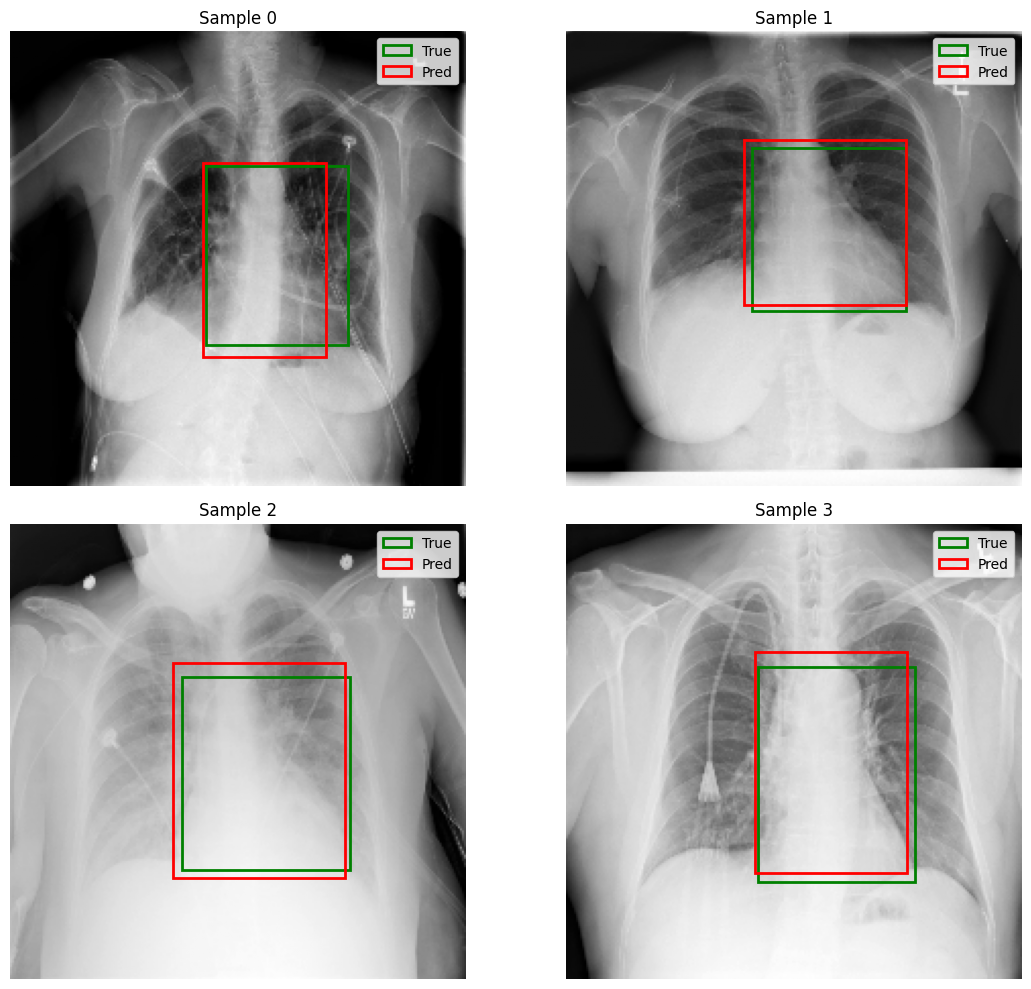

In [14]:
show_predictions(val_dataset, preds, labels, [0, 1, 2, 3])

In [15]:
# Check checkpoint info
checkpoint = torch.load("weight.ckpt", map_location='cpu')
print("Checkpoint info:")
if 'epoch' in checkpoint:
    print(f"Epoch: {checkpoint['epoch']}")
if 'global_step' in checkpoint:
    print(f"Global step: {checkpoint['global_step']}")

Checkpoint info:
Epoch: 100
Global step: 5000


In [16]:
import glob

# Check what's in the logs directory
log_checkpoints = glob.glob("./logs/**/checkpoints/*.ckpt", recursive=True)
print("Checkpoints in logs:")
for ckpt in log_checkpoints:
    print(f"  {ckpt}")

# Check if weights directory exists and has checkpoints  
weights_checkpoints = glob.glob("./weights/**/*.ckpt", recursive=True)
print("\nCheckpoints in weights:")
for ckpt in weights_checkpoints:
    print(f"  {ckpt}")

print(f"\nRoot checkpoint: weight.ckpt (Epoch 100)")

Checkpoints in logs:
  ./logs/lightning_logs/version_1/checkpoints/epoch=58-Val Loss=32.35.ckpt
  ./logs/lightning_logs/version_1/checkpoints/epoch=83-Val Loss=32.79.ckpt
  ./logs/lightning_logs/version_1/checkpoints/epoch=68-Val Loss=32.13.ckpt

Checkpoints in weights:

Root checkpoint: weight.ckpt (Epoch 100)


Checkpoints in logs:
  ./logs/lightning_logs/version_1/checkpoints/epoch=58-Val Loss=32.35.ckpt
  ./logs/lightning_logs/version_1/checkpoints/epoch=83-Val Loss=32.79.ckpt
  ./logs/lightning_logs/version_1/checkpoints/epoch=68-Val Loss=32.13.ckpt

Checkpoints in weights:

Root checkpoint: weight.ckpt (Epoch 100)
